In [1]:
#Data import using Numpy

import numpy as np
import csv
import random
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import norm
%matplotlib inline


__Load Data File__

We are using csv reader to load data file to our numpy array

In [2]:
data_dir = "data/"
file_name = data_dir + "BasicDefaultTypeEMG.csv"

reader = csv.reader(open(file_name, "rb"), delimiter=",")
data_file = pd.read_csv(file_name, sep=',',header=0);
x = list(reader)
print x[0]
result = np.array(x[1:])
print data_file.columns

/Users/shafidayatar/anaconda/envs/python2.7-DA/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['timestamp', 'pod1', 'pod2', 'pod3', 'pod4', 'pod5', 'pod6', 'pod7', 'pod8', 'connected', 'arm_synched', 'device_direction', 'warmupState', 'synced', 'battery_level', 'rssi', 'bluetooth_strength', 'player_hand', 'grip_type']
Index([u'timestamp', u'pod1', u'pod2', u'pod3', u'pod4', u'pod5', u'pod6',
       u'pod7', u'pod8', u'connected', u'arm_synched', u'device_direction',
       u'warmupState', u'synced', u'battery_level', u'rssi',
       u'bluetooth_strength', u'player_hand', u'grip_type'],
      dtype='object')


__Extract Imp Featurs__

From the loaded data, we are extracting main features that is emg pods value which is collected from myo arm band device, this will be feeded in the neural network. We extract the target value from the file and store it in the grips_data.


In [3]:
#Number of rows that is going to be processed
#Number of each defined for each classificatinon
emg_pods = data_file
emg_pods = result[33142:,1:9].astype('float64')
emg_pods = data_file[['pod1', 'pod2', 'pod3', 'pod4', 'pod5', 'pod6', 'pod7', 'pod8']]
emg_pods = emg_pods[33142:] 
grips_data = result[33142:,-1]
grips_data = data_file['grip_type']
grips_data = grips_data[33142:]
time = result[33142:,0]
grip_types = np.unique(grips_data)

print emg_pods.shape
print time.shape
for grip in grip_types:
    print("%s  Rows  are %d" % (grip, len(grips_data[grips_data ==grip])))


(86991, 8)
(86991,)
The Continental Grip  (Bevel #2)  Rows  are 21243
The Eastern Forehand Grip (Bevel #3)  Rows  are 18314
The Semi-Western Forehand Grip (Bevel #3)  Rows  are 22999
The Western Forehand Grip (Bevel #5)  Rows  are 24435


__Feature Scaling__

We are normalizing our data using standard scaler, we should try different scaler to find out the result

In [4]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(emg_pods)
emg_pods =  scaled_data


In [5]:

time = np.arange(5, (time.shape[0]+1)*5, 5)
print time.shape
print time[-5]
#time = np.diff(time, n=1)


(86991,)
434935


__Analyzing the data__

We are taking standard deviation and mean of the emg pods, using this value we are ploting a normal distribution graphs. 

We are also using scatter to plot to define a correlation between pod values and grip types.



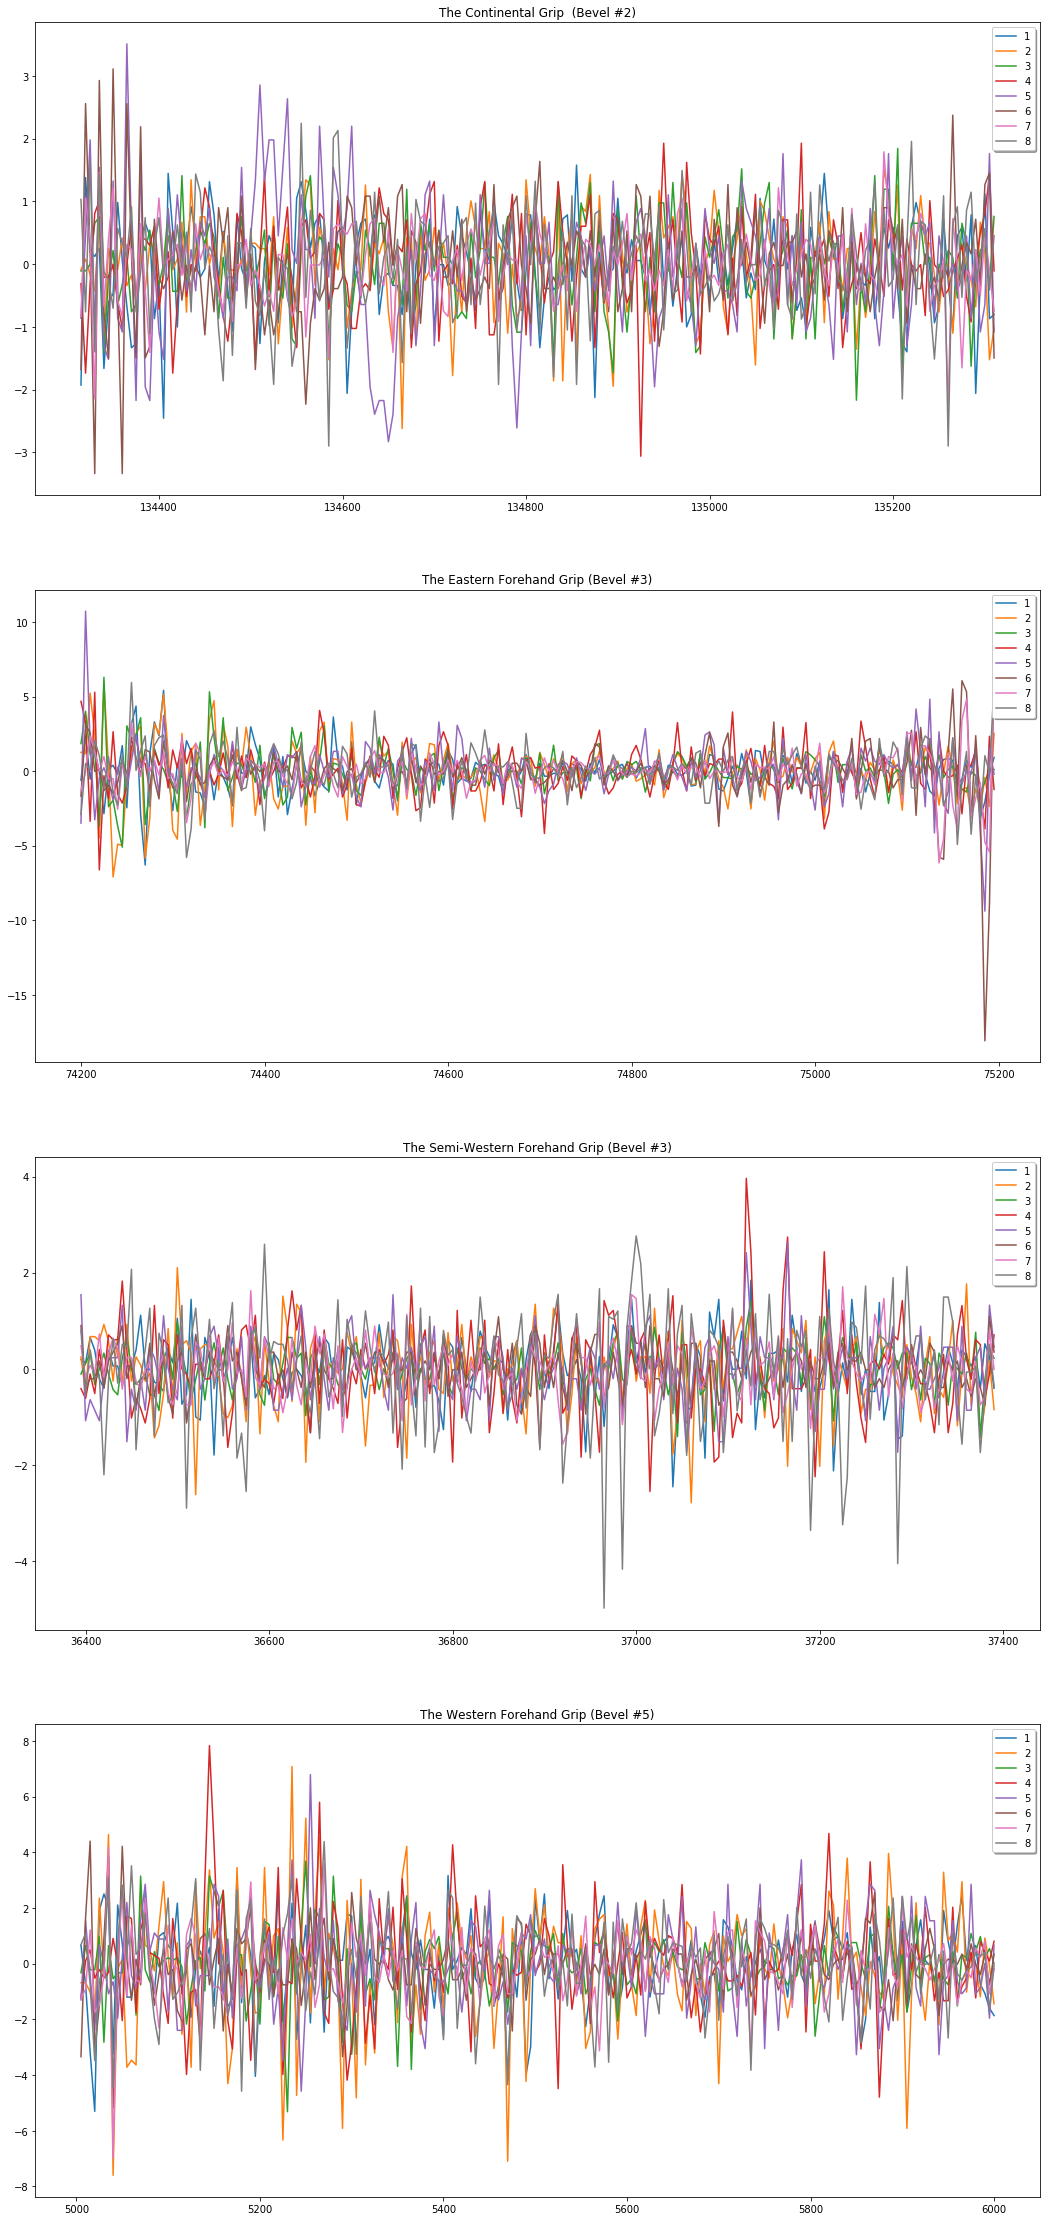

In [7]:

grip_count = 4
s_fig, s_axs = plt.subplots(nrows=4, ncols=1, figsize=(18,40)) 


for type_id in range(grip_count):
    #figs, axs = plt.subplots(nrows=8, ncols=1, figsize=(18,10))
    random_select = random.sample(range(15000), 30)
    y = emg_pods[grips_data == grip_types[type_id]] #semi western
    x = time[grips_data == grip_types[type_id]]
    #y = (np.random.rand(len(random_select), 1) + type_id)
    #sd = np.std(t, axis=0)
    #mean = np.mean(t, axis=0)
    #color=next(colors)
    #colors = iter(cm.rainbow(np.linspace(0, 1, 8)))
    s_axs[type_id].plot(x[1000:1200], y[1000:1200])
    s_axs[type_id].legend('12345678',shadow=True, fancybox=True, loc="upper right");
    s_axs[type_id].set_title(grip_types[type_id])

    # Mean = 0, SD = 2.
    """for i in range(8):
        #s_axs[type_id].scatter(t[random_select,i], y, color=next(colors))
        #s_axs[type_id].plot(mean[i].repeat(30), y)
        #x_axis = np.arange(np.min(t[:,i]), np.max(t[:,i]), 1)
        axs[i].plot(x[1000:1200], y[1000:1200,i], label = "pod" + str(i))
        #s_axs[type_id].set_title("Grip Type %s" % grip_types[type_id])
        axs[i].legend('1',shadow=True, fancybox=True, loc="upper right");
        axs[type_id].set_title(grip_types[type_id]  + " pod " + str(i))"""


__Label Classifiers__

We are using one hot encoding, for the grip types coloumn

Working => 

grips_data["conti.", "western", etc]

then resultant vector would

[[1,0,0,0], [0,0,0,1],..etc] 

In [8]:
#Data Preprossing
#removing extra coloumns
# onehot encoding - label classifier

from sklearn.preprocessing import OneHotEncoder,LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(grips_data)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y_labels = onehot_encoder.fit_transform(integer_encoded)


#prepare training-set, test-set, valid-set.


__Preparing Data Set__

We are using train test split, to create a Training and Test data.
Also we are using half of the test data as validation data set which
well help us check how out model is performing on the go

In [1]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(emg_pods, Y_labels,  test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)



print X_train.shape[1]
print X_test.shape
print X_val.shape

NameError: name 'emg_pods' is not defined

In [63]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Conv1D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, LeakyReLU
from keras.models import Sequential

In [98]:
#Create MultiLayer Perceptron Network
def model_linear():
    model = Sequential()
    model.add(Dense(16, input_shape=(8,), activation = 'relu', kernel_initializer='truncated_normal'))
    model.add(Dense(len(grip_types), activation='softmax', kernel_initializer='truncated_normal'))
    model.summary()
    return model

In [65]:

def model_cnn_1d():
    model = Sequential()

    model.add(Conv1D(32, 1, activation='relu', input_shape=(8,1)))
    model.add(Conv1D(64, 1, activation='relu'))
    model.add(Dropout(.4))
    model.add(Conv1D(128, 2, activation='relu', ))
    model.add(Conv1D(128, 2, activation='relu', ))
    model.add(Dropout(.4))
    model.add(Conv1D(256, 3, activation='relu', ))
    model.add(Conv1D(256, 3, activation='relu', ))
    model.add(Dropout(.4))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.4))
    model.add(Dense(len(grip_types), activation='softmax', kernel_initializer='truncated_normal'))

    model.summary()
    return model


In [109]:

def model_cnn_2d():
    model = Sequential()

    model.add(Conv1D(32, 3, activation='relu', input_shape=(10,8)))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(Dropout(.4))
    model.add(Conv1D(128, 3, activation='relu', ))
    model.add(Conv1D(128, 3, activation='relu', ))
    model.add(Dropout(.4))
    model.add(Conv1D(256, 3, activation='relu', ))
    model.add(Conv1D(256, 3, activation='relu', ))
    model.add(Dropout(.4))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.4))
    model.add(Dense(len(grip_types), activation='softmax', kernel_initializer='truncated_normal'))

    model.summary()
    return model


In [42]:
#Test MultiLayer Network
def model_compile(model, loss, optimizer, metrics):
    #model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss = loss, optimizer=optimizer, metrics=metrics)
    return model



In [66]:
def run_model(model, data=(), verbose=1, epochs=20, batch_size=32,):
    model.fit(data[0], data[1], epochs=epochs, batch_size=batch_size, validation_data=(data[2], data[3]),verbose=1)

In [106]:
def test_model(model, test_data_x, test_data_y, expand=()):
    #print ("shape of test data is %s" % (test_data_x.shape,))
    if expand[0]:
        model_prediction = [np.argmax(model.predict(np.expand_dims(test_vector, axis=expand[1]))) for test_vector in test_data_x]
    #else:
    #model_prediction = [np.argmax(model.predict(np.expand_dims(test_vector, axis=0))) for test_vector in test_data_x[:]]
        
    # report test accuracy
    test_accuracy = 100*np.sum(np.array(model_prediction)==np.argmax(test_data_y, axis=1))/len(model_prediction)
    print('Test accuracy: %.4f%%' % test_accuracy)

In [108]:
## test Liner model

linear_model = model_linear()
linear_model= model_compile(linear_model, 'categorical_crossentropy', 'adam', ['accuracy'])
run_model(linear_model, data=(X_train, y_train, X_val, y_val), epochs=5)
print X_test.shape
test_model(linear_model, X_test, y_test, (False,0))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_45 (Dense)             (None, 4)                 68        
Total params: 212
Trainable params: 212
Non-trainable params: 0
_________________________________________________________________
Train on 60893 samples, validate on 13049 samples
Epoch 1/5
60893/60893 [==============================] - 4s 72us/step - loss: 1.3482 - acc: 0.3104 - val_loss: 1.3289 - val_acc: 0.3281
Epoch 2/5
60893/60893 [==============================] - 4s 58us/step - loss: 1.3198 - acc: 0.3365 - val_loss: 1.3182 - val_acc: 0.3440
Epoch 3/5
60893/60893 [==============================] - 4s 58us/step - loss: 1.3131 - acc: 0.3468 - val_loss: 1.3126 - val_acc: 0.3586
Epoch 4/5
60893/60893 [==============================] - 3s 56us/step - loss: 1.30

In [73]:

cnn_x_train = np.expand_dims(X_train, axis=2)
cnn_x_val = np.expand_dims(X_val, axis=2)
cnn_x_test = np.expand_dims(X_test, axis=2)


## test Liner modeld
cnn_1d_model = model_cnn()# (cnn_x_train[1], cnn_x_train[2]))
cnn_1d_model= model_compile(cnn_1d_model, 'categorical_crossentropy', 'adam', ['accuracy'])
run_model(cnn_1d_model, data=(cnn_x_train, y_train, cnn_x_val, y_val), epochs=5)
test_model(cnn_1d_model, cnn_x_test, y_test, (True,2))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 8, 32)             64        
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 8, 64)             2112      
_________________________________________________________________
dropout_13 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 7, 128)            16512     
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 6, 128)            32896     
_________________________________________________________________
dropout_14 (Dropout)         (None, 6, 128)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 4, 256)            98560     
__________

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix


## we need a better way analyse the confusion matrix for 133 labels.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
test_targets_result = np.argmax(y_test, axis=1)
cnf_matrix = confusion_matrix(model_prediction[1:100], test_targets_result[1:100])
np.set_printoptions(precision=2)
print cnf_matrix

cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized confusion matrix")
print cm
# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=grip_types,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=grip_types, normalize=True,
                      title='Normalized confusion matrix')

#plt.show()

In [ ]:
##testing live data 


from collections import Counter
def read_emg_from_file(file_name):
    reader = csv.reader(open(file_name, "rb"), delimiter=",")
    data = list(reader)
    data_set = np.array(x[1:])[:,1:9].astype('float64')
    return data_set
    

def detect_grip(filename):
    predict_data_set =  read_emg_from_file(file_name)
    predict_data_set = np.expand_dims(predict_data_set, axis=2)
    model_prediction = [np.argmax( model.predict(np.expand_dims(test_vector, axis=0))) for test_vector in predict_data_set]
    counter = Counter(model_prediction).most_common(4)
    return grip_types[counter[0][0]]
    


In [ ]:
file_name = data_dir + "test_continental.csv"
print detect_grip(file_name)

In [ ]:
##testing live data 
file_name = data_dir + "test_semiwesternfore.csv"
print detect_grip(file_name)


In [ ]:


##testing live data 
file_name = data_dir + "test_eastfore.csv"
print detect_grip(file_name)

In [ ]:

##testing live data 
file_name = data_dir + "test_westernfore.csv"
print detect_grip(file_name)